## Prepare Data

In [1]:
import os
if os.path.isdir('/content/noise-ecg-classification/data_10s'):
    data_path = '/content/noise-ecg-classification/data_10s'
    ! git clone https://github.com/ernestchu/noise-ecg-classification
else:
    data_path = '../../data_10s'

### Load Data

In [2]:
import torch
import torch.nn as nn
import numpy as np
import h5py
import os

class DB10s(torch.utils.data.Dataset):
    def __init__(self):
        self.h5_list = []
        for dir in os.listdir(data_path):
            if len(dir) != 3:
                dir = os.path.join(data_path, dir)
                for file in os.listdir(dir):
                    path=os.path.join(dir, file)
                    with h5py.File(path, 'r') as f:
                        if len(f['MLII'][:])==3600:
                            noNoisePath=os.path.join(dir[:-3], file)
                            self.h5_list.append((path, noNoisePath))

    def __getitem__(self, index):
        path, noNoisePath = self.h5_list[index]
        with h5py.File(path, 'r') as f, h5py.File(noNoisePath, 'r') as f2:
            MLII = torch.tensor(f['MLII'][:])
            return {
            'MLII': torch.tensor(f['MLII'][:]).float(),
            'target MLII': torch.tensor(f2['MLII'][:]).float(),
            }
    def __len__(self):
        return len(self.h5_list)

dataset = DB10s()

dataset length: 1080


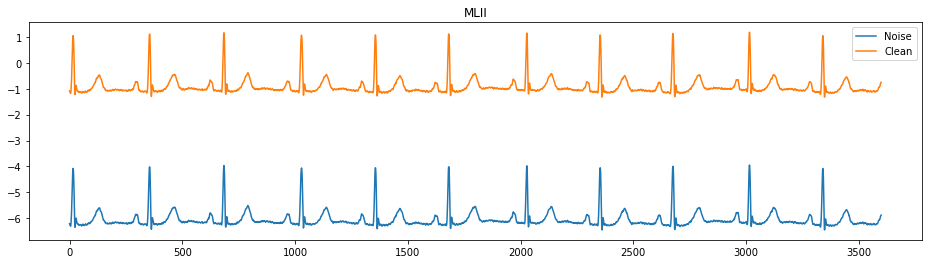

In [3]:
import matplotlib.pyplot as plt
print('dataset length:', len(dataset))


sampleIndice=10
figsize=(16,4)
# print ("sample length:", len(dataset[sampleIndice]['MLII']))

plt.figure(figsize=figsize)
plt.plot(dataset[sampleIndice]['MLII'], label='Noise')
plt.plot(dataset[sampleIndice]['target MLII'], label='Clean')
plt.title('MLII')
plt.legend()
plt.show()

In [4]:
trainDataLen=int(len(dataset)*.7)
testDataLen=len(dataset)-trainDataLen
dataset_train, dataset_test=torch.utils.data.random_split(dataset, [trainDataLen, testDataLen])
print('train dataset length:', trainDataLen)
print('test dataset length:', testDataLen)

from torch.utils.data import DataLoader
batch_size = 32
train_data = DataLoader(dataset_train, batch_size=batch_size, drop_last=True, shuffle=True)
test_data = DataLoader(dataset_test, batch_size=batch_size, drop_last=True)

train dataset length: 756
test dataset length: 324


In [5]:
import torch
from torch import nn
import torch.nn.functional as F

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv1d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm1d(out_size))
        layers.append(nn.Tanh())
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose1d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm1d(out_size),
            nn.Tanh(),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        if x.shape[-1] != skip_input.shape[-1]:
            x = F.pad(x, (0, 1))
        x = torch.cat((x, skip_input), 1)

        return x

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AutoEncoder, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(128, out_channels, 4, padding=1),
            nn.ConstantPad1d((0, 1), 0),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [7]:
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoEncoder().to(device)
criterion = nn.MSELoss()

optim = optim.Adam(model.parameters(), lr=1e-3, betas=(.9, 0.99))
# optim = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Training Loop

In [8]:
outputs=None
groundTruth=None
noiseData=None
def iterate(train, input_data, model, optimizer):
    '''
    Argement:
    train -- to train or not
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    label_criterion, attr_criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    if train:
        model.train()
    else:
        model.eval()

    loss_list = []
    total_count = 0
    acc_count = 0
    for i, data in enumerate(input_data, start=1):
        MLII, targetMLII = data['MLII'].to(device), data['target MLII'].to(device)
        input=MLII
        input=input.reshape(input.shape[0], 1, input.shape[1])
        target=targetMLII
        target=target.reshape(target.shape[0], 1, target.shape[1])
        global groundTruth
        groundTruth=target
        global noiseData
        noiseData=input
        if train:
            optimizer.zero_grad()

        if i%40==0:
            print(i,'/',len(input_data))
        with torch.set_grad_enabled(train):
            global outputs
            outputs = model(input)
            loss = criterion(outputs, target)
            if train:
                loss.backward()
                optimizer.step()

        loss_list.append(loss.item())

    # Compute this epoch accuracy and loss
    loss = sum(loss_list) / len(loss_list)
    return loss

def train(input_data, model, optimizer):
    return iterate(True, input_data, model, optimizer)

def val(input_data, model):
    return iterate(False, input_data, model, None)

In [9]:
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
best_loss=100000000

In [10]:
# model.load_state_dict(torch.load('/content/drive/My Drive/bert_progress'))
# print('Loaded from storage')

In [11]:
def drawDenoised(i):
    fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    axs[0].set_title('Ground Truth')
    axs[0].plot(groundTruth[i][0].cpu())
    axs[1].set_title('Generated')
    axs[1].plot(outputs[i][0].detach().cpu())
    axs[2].set_title('Noise Data')
    axs[2].plot(noiseData[i][0].detach().cpu())
    plt.show()

Epoch 100
Train: Loss: 0.005970
  Val: Loss: 0.011143
Learning Rate: 1e-05




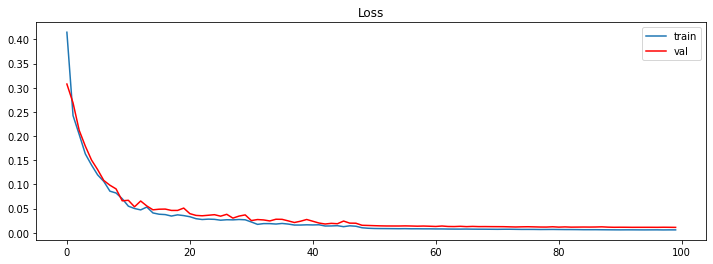

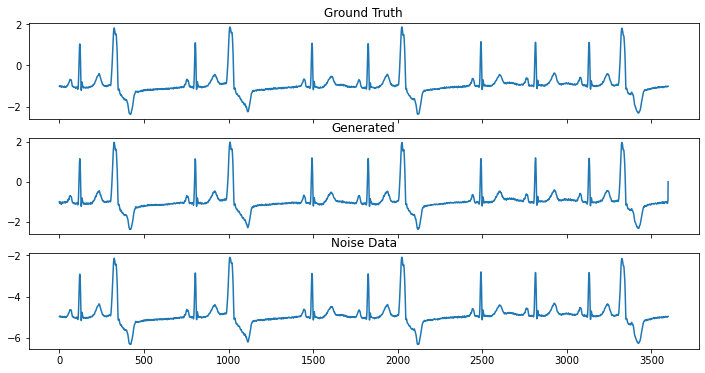

Saved to ../weights/DAE_param.pth


In [12]:
import copy
from IPython.display import clear_output
import matplotlib.pyplot as plt
################################################################################
# You can adjust those hyper parameters to loop for max_epochs times           #
################################################################################
max_epochs = 100
log_interval = 5 # print acc and loss in per log_interval time
################################################################################
#                               End of your code                               #
################################################################################
 
# if 'best_model_state'  in globals():
#   model.load_state_dict(best_model_state)
#   print('Loaded from variable')
# else:
 
SAVE_PATH_model_state_dict='../weights/DAE_param.pth'
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=4, verbose=False)
startEpoch=1
for epoch in range(startEpoch, startEpoch+max_epochs):
    train_loss = train(train_data, model, optim)
    val_loss = val(test_data, model)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    if epoch % log_interval == 0:
        clear_output()
        s=f'Epoch {epoch}\n'
        s+='Train: Loss: {:.6f}\n'.format(train_loss)
        s+='  Val: Loss: {:.6f}\n'.format(val_loss)
        for param_group in optim.param_groups:
            s+='Learning Rate: {}\n\n'.format(param_group['lr'])
        print(s)

        plt.figure(figsize=(12, 4))
        plt.plot(range(len(train_loss_list)), train_loss_list)
        plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
        plt.legend(['train', 'val'])
        plt.title('Loss')
        plt.show()


        drawDenoised(25)

    if val_loss < best_loss:
        best_model_state = copy.deepcopy(model.state_dict())
        best_loss = val_loss
        torch.save(best_model_state, SAVE_PATH_model_state_dict)
        print('Saved to', SAVE_PATH_model_state_dict)

    scheduler.step(val_loss)